In [23]:
# -*- coding: utf-8 -*-
import os
import pandas as pd
import numpy as np
import join
import csv
import sys
import jieba
import time
import jieba.analyse
import jieba.posseg as pseg
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from collections import Counter
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from tkinter import _flatten
import pickle
from PIL import Image
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator
print("【訊息】目前的工作目錄:",os.getcwd())

【訊息】目前的工作目錄: D:\Mypython\專題


### 範例

In [ ]:
a =[1,2,3,4,1,2]
c = ['This','is','a','random','string','!']
df = pd.DataFrame({'A':a,'C':c})
df

In [ ]:
QQ = df.groupby('A')['C'].apply(lambda x: "%s" % ''.join(x))
QQ

In [ ]:
QQ = list(QQ)
QQ

### 實作-資料清理與分群

In [4]:
#開啟欄位到最大，方便 pandas 匯入檔案
csv.field_size_limit(int(sys.maxsize/10000000000))

131072

In [3]:
#檔案的匯入
df=pd.read_csv(r'D:\Mypython\專題\deal(469mb;546Krows)_0605v5.csv', sep=',', engine='python')

In [4]:
df.shape

(546216, 45)

In [5]:
df.columns

Index(['business_hour_guid', 'seller_GUID', 'business_hour_order_time_s',
       'business_hour_order_time_e', 'business_hour_deliver_time_s',
       'business_hour_deliver_time_e', 'pic_alt', 'zip_code', 'city_name',
       'district_name', 'item_name', 'item_orig_price', 'item_price',
       'item_default_daily_amount', 'event_name', 'event_title',
       'product_spec', 'shopping_cart', 'combo_pack_count',
       'quantity_multiplier', 'city_list', 'deal_acc_business_group_id',
       'acc_business_group_name', 'deal_type', 'is_travel_deal',
       'installment_3months', 'installment_6months', 'installment_12months',
       'deny_installment', 'shippingdate', 'is_long_contract',
       'develope_sales_id', 'operation_sales_id', 'slug', 'ordered_quantity',
       'ordered_total', 'category_list', 'freight_amount', 'enable_isp',
       'discount_price', 'is_wms', 'ancestor_business_hour_guid', 'code_name',
       'code', 'newCode'],
      dtype='object')

In [6]:
df.groupby('newCode').size()

newCode
0          1953
2           361
4             4
5             1
7             1
100          51
106          44
107          53
108           5
142           6
143          24
166        7066
169           5
170           5
173          46
177          15
178          21
181           6
182         715
187         154
196           6
201           3
203          35
204          80
207          23
209        1525
212          50
213           1
214        1217
215         834
          ...  
5872        112
5886          2
5910       5723
6346          1
6347          1
6392         11
6551          8
6716        121
6873       3890
7160       1033
7428        113
8233       1253
8234       2899
8298        670
8483       2907
499797        1
499906     1241
499969     1877
499989     8962
499991       15
500035    15548
503759      403
503760      295
505287     1281
505666     5754
505764        1
505766     1829
505771    16459
505801        4
505826       14
Length: 450, dty

In [7]:
df.head(2)

,business_hour_guid,seller_GUID,business_hour_order_time_s,business_hour_order_time_e,business_hour_deliver_time_s,business_hour_deliver_time_e,pic_alt,zip_code,city_name,district_name,...,ordered_total,category_list,freight_amount,enable_isp,discount_price,is_wms,ancestor_business_hour_guid,code_name,code,newCode
0,29B37E53-021C-48E9-909E-C6C151974AC7,EC5DDAD4-F8F8-418B-8AED-7BAC2553F2B6,00:00.0,00:00.0,00:00.0,00:59.0,柯絲妃兒/胎盤素/肌因賦活/身體精華乳,407,台中市,西屯區,...,0,[88|221|124|769|136|139],0,0,NaN,0,NaN,美體私密,5821.0,5821
1,2C6E83A9-9785-4593-A759-07A78AB309BB,B6CC8A1E-37C8-44E5-B6E2-15123387AF95,00:00.0,00:00.0,00:00.0,00:59.0,aibo 領導者/ 立體聲/智慧藍牙/耳機麥克風系列,243,新北市,泰山區,...,0,[88|221|117|2179|2180|100105|100106|136|139],0,0,NaN,0,NaN,網路設備/穿戴裝置/辦公設備,222.0,505771


In [8]:
# 匯入停用詞庫，放進list
stopword =[]
for i in open(r'D:\Mypython\專題\停用.txt') :
    stopword.append(i.rstrip())

In [26]:
# 轉化欄為型態
df['item_name'] = df['item_name'].astype('str')

In [27]:
df['code_name'] = df['code_name'].astype('str').apply(lambda x:x.replace('/',''))

In [11]:
# 將資料去除停用詞
def clearword(x):
    l = []
    out =''
    l = jieba.cut(x)
    for j in l:
        if j not in stopword:
            out = out+j
    return out

In [28]:
# 清理
df['item_name'] = df['item_name'].apply(lambda x:x.replace(' ','').replace('(','').replace(')','').replace('|',''))

In [13]:
# 停用詞去除
df['item_name'] = df['item_name'].apply(clearword)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\andy\AppData\Local\Temp\jieba.cache
Loading model cost 0.677 seconds.
Prefix dict has been built succesfully.


In [ ]:
def clearword2(x):
    out =''
    p = ['m','q','a']
    words = pseg.cut(x)
    for i in words:
        if i.flag not in p:
            out = out+i.word
    return out

In [ ]:
%%time

df['item_name'] = df['item_name'].apply(clearword2)

In [ ]:
df['item_name'].to_csv(r"D:\MyPython\專題\clearword2.csv", encoding='utf_8_sig')

In [14]:
# 2個欄位結合
df['name'] = df['item_name']+df['code_name']

In [15]:
df['name']

0                       柯絲妃兒胎盤素肌因賦活身體精華乳美體私密
1                領導者立體聲智慧藍牙耳機麥克風網路設備穿戴裝置辦公設備
2                領導者立體聲智慧藍牙耳機麥克風網路設備穿戴裝置辦公設備
3                領導者立體聲智慧藍牙耳機麥克風網路設備穿戴裝置辦公設備
4                領導者立體聲智慧藍牙耳機麥克風網路設備穿戴裝置辦公設備
5                領導者立體聲智慧藍牙耳機麥克風網路設備穿戴裝置辦公設備
6                          黑橋牌香腸原味蒜味即食調理熟食小吃
7                          黑橋牌香腸原味蒜味即食調理熟食小吃
8                          黑橋牌香腸原味蒜味即食調理熟食小吃
9                          黑橋牌香腸原味蒜味即食調理熟食小吃
10                         黑橋牌香腸原味蒜味即食調理熟食小吃
11                             水林號冰心地瓜農產蔬菜水果
12                 膳魔師超輕量鏽鋼真空保溫杯保溫生活百貨衛浴設備用品
13                                 匯鮮鮭魚生鮮肉品蛋
14                   拳擊有氧健身特厚多功能拳擊沙袋健身器材測量器材
15                   拳擊有氧健身直立式拳擊球拳擊座健身器材測量器材
16                   拳擊有氧健身特厚多功能拳擊沙袋健身器材測量器材
17             拳擊有氧健身特厚多功能拳擊沙袋半指拳擊手套健身器材測量器材
18                     尚順育樂一票暢遊尚順晴天雨天玩HIGH門票
19                                尚順育樂門票四張門票
20             拳擊有氧健身直立式拳擊球拳擊座競技拳擊手套健身器材測量器材
21        iPhone7iPhone7plus0.28超薄軟殼電腦平板手機配件
22        

In [16]:
# 同類別的groupby在一起
Join_name = df.groupby('code')['item_name'].apply(lambda x: "%s" % ''.join(x))

In [17]:
Join_name = list(Join_name)

In [18]:
Join_name[0]

"芝麻街夏日鋁箔壓花涼墊L號芝麻街夏日鋁箔壓花涼墊L號芝麻街夏日鋁箔壓花涼墊M號芝麻街夏日鋁箔壓花涼墊L號芝麻街夏日鋁箔壓花涼墊芝麻街夏日鋁箔壓花涼墊M號芝麻街夏日鋁箔壓花涼墊M號寵物項圈床墊組寵物汽車防汙墊寵物汽車防汙墊寵物汽車防汙墊寵物汽車防汙墊寵物汽車防汙墊昊伸涼席寵物窩小搖籃昊伸編織竹席冰墊3L昊伸編織竹席冰墊L昊伸寵物涼蓆昊伸折疊式寵物涼墊L昊伸編織竹席冰墊昊伸折疊式寵物涼墊菱牌寵物剪毛菱牌充插寵物電動剪毛器薄刀菱牌充插寵物電動剪毛器大厚刀菱牌插電型寵物剪毛器薄刀凝膠寵物墊鋁箔壓花冰墊鋁箔寵物墊中凝膠寵物墊特大凝膠寵物墊凝膠寵物墊特大夏日寵物墊鋁箔寵物墊中鋁箔壓花冰墊寵物吸盤吊床睡床寵物吸盤吊床睡床寵物吸盤吊床睡床寵物吸盤吊床睡床鋁箔壓花冰墊鋁箔壓花冰墊FURminator除毛梳犬用L號FURminator科德士寵物毛梳電剪科德士寵物電推剪FURminator除毛梳犬用XS號FURminator除毛梳貓M號防水靜音寵物電剪FURminator除毛梳犬用號FURminator除毛梳貓S號凝膠寵物墊夏日寵物墊鋁箔寵物墊中凝膠寵物墊凝膠寵物墊特大鋁箔寵物墊中凝膠寵物墊特大ChilliPet羊羔絨舒適圓窩ChilliPet羊羔絨舒適圓窩ChilliPet羊羔絨舒適圓窩ChilliPet羊羔絨舒適圓窩美樂狗寵物套餐美樂狗寵物套餐美樂狗寵物套餐美樂狗寵物套餐柔軟南瓜寵物抽繩窩柔軟南瓜寵物抽繩床窩柔軟南瓜寵物抽繩床窩柔軟南瓜寵物抽繩床窩柔軟南瓜寵物抽繩床窩柔軟南瓜寵物抽繩床窩柔軟南瓜寵物抽繩床窩柔軟南瓜寵物抽繩床窩寵物項圈床墊組時尚項圈桃紅水鑽項圈寵物小綿羊造型床墊寵物貪睡狗造型床墊寵物貪睡狗造型床墊時尚項圈桃紅水鑽項圈寵物花朵造型床墊寵物花朵造型床墊寵物小綿羊造型床墊愛羊羔絨五彩寵物窩愛羊羔絨五彩寵物窩愛羊羔絨五彩寵物窩愛羊羔絨五彩寵物窩愛羊羔絨五彩寵物窩愛中號羊羔絨五彩寵物窩愛羊羔絨五彩寵物窩愛中號羊羔絨五彩寵物窩愛羊羔絨五彩寵物窩愛中號羊羔絨五彩寵物窩愛蒙古包寵物窩愛中號蒙古包寵物窩愛蒙古包寵物窩愛中號蒙古包寵物窩愛蒙古包寵物窩愛中號蒙古包寵物窩愛蒙古包寵物窩羊羔絨寵物保暖窩羊羔絨寵物保暖窩羊羔絨寵物保暖窩羊羔絨寵物保暖窩羊羔絨寵物保暖窩羊羔絨寵物保暖窩羊羔絨寵物保暖窩柔軟抽繩寵物墊窩柔軟抽繩寵物墊窩柔軟抽繩寵物墊窩柔軟抽繩寵物墊窩柔軟抽繩寵物墊窩柔軟抽繩寵物墊窩

In [22]:
df_Join_name = pd.DataFrame(Join_name)

In [23]:
df_Join_name.columns = ['Join_name']
df_Join_name

,Join_name
0,芝麻街夏日鋁箔壓花涼墊L號芝麻街夏日鋁箔壓花涼墊L號芝麻街夏日鋁箔壓花涼墊M號芝麻街夏日鋁箔...
1,HAPPYHOUSE矽藻土寵物乾洗噴霧HAPPYHOUSE矽藻土寵物乾洗噴霧HAPPYHOU...
2,寵物多功能沐浴寵物多功能沐浴寵物多功能沐浴寵物多功能沐浴寵物多功能沐浴寵物益智漏食球寵物益智...
3,BABYTIGER遊戲爬行巧拼地墊莊園BABYTIGER遊戲爬行巧拼地墊莊園BABYTIGE...
4,韓版休閒百搭多口袋雙肩背包韓版休閒百搭多口袋雙肩背包韓版休閒百搭多口袋雙肩背包韓版休閒百搭多...
5,韓版防潑水旅行折疊背包行李可套拉桿單肩包韓版防潑水旅行折疊背包行李可套拉桿單肩包韓版防潑水旅...
6,鑽石甜心ABS霧面行李箱吋鑽石甜心ABS霧面行李箱吋鑽石甜心ABS霧面行李箱鑽石甜心ABS霧...
7,大容量摺疊掛勾收納包大容量摺疊掛勾收納包大容量摺疊掛勾收納包大容量摺疊掛勾收納包大容量摺疊掛...
8,超廣角微距鏡頭超廣角微距鏡頭超廣角微距鏡頭0.45X超廣角微距鏡頭超廣角微距鏡頭超廣角微距鏡...
9,COOLPON高清光學玻璃特效鏡頭COOLPON高清光學玻璃特效鏡頭COOLPON高清光學玻...


In [24]:
df_Join_name.to_csv(r"D:\MyPython\專題\Join-name2.csv", encoding='utf_8_sig')

### tf-idf 進行數字化

In [5]:
df2=pd.read_csv(r'D:\Mypython\專題\Join-name2.csv', sep=',', engine='python',encoding='utf_8_sig')

In [6]:
# 結巴切段
def word_cut(mytext):
    return list(jieba.cut(mytext))

In [7]:
# 資料型態轉換
df2['Join_name'] = df2['Join_name'].astype('str')

In [8]:
df2['content_cutted'] = df2['Join_name'].apply(word_cut)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\andy\AppData\Local\Temp\jieba.cache
Loading model cost 0.747 seconds.
Prefix dict has been built succesfully.


In [9]:
df2['content_cutted']

0      [芝麻街, 夏日, 鋁箔, 壓花涼, 墊, L, 號, 芝麻街, 夏日, 鋁箔, 壓花涼, ...
1      [HAPPYHOUSE, 矽藻, 土寵物, 乾洗, 噴霧, HAPPYHOUSE, 矽藻, ...
2      [寵物, 多功能, 沐浴, 寵物, 多功能, 沐浴, 寵物, 多功能, 沐浴, 寵物, 多功...
3      [BABYTIGER, 遊戲, 爬行, 巧拼地, 墊, 莊園, BABYTIGER, 遊戲,...
4      [韓版休, 閒百搭多, 口袋, 雙肩, 背包, 韓版休, 閒百搭多, 口袋, 雙肩, 背包,...
5      [韓版, 防潑, 水, 旅行, 折疊, 背包, 行李, 可套, 拉桿, 單肩包, 韓版, 防...
6      [鑽石, 甜心, ABS, 霧面, 行李箱, 吋, 鑽石, 甜心, ABS, 霧面, 行李箱...
7      [大容量, 摺, 疊掛, 勾, 收納包, 大容量, 摺, 疊掛, 勾, 收納包, 大容量, ...
8      [超廣角, 微距, 鏡頭, 超廣角, 微距, 鏡頭, 超廣角, 微距, 鏡頭, 0.45, ...
9      [COOLPON, 高清, 光學, 玻璃, 特效, 鏡頭, COOLPON, 高清, 光學,...
10     [SUPERGA, 義國民, 經典, 男女, 款休, 閒鞋, SUPERGA, 義國民, 經...
11     [免鑽孔, 伸縮, 自動, 扣, 皮帶, 條免, 鑽孔, 伸縮, 自動, 扣皮, 帶免, 鑽...
12     [灣, 製, 抗, UV, 防曬止, 滑, 全指, 手套, 灣, 製, 抗, UV, 防曬止...
13     [男女, 防曬, 休閒戶, 外漁夫, 登山, 男女, 防曬, 休閒戶, 外漁夫, 登山, 男...
14     [度抗, UV, 護頸防, 曬, 口罩, 度抗, UV, 護頸防, 曬, 口罩, 度抗, U...
15     [防曬抗, 3C, 藍光, 眼鏡, 夾片, 防曬抗, 3C, 藍光, 眼鏡, 夾片, 防曬抗...
16     [超, 超自然, U, 型, 髮, 超, 超自然, U, 型, 髮, 超, 超自然, U, ...
17     [春夏, 款日系, 套裝, 春夏, 款日系, 套

In [10]:
df_Join_name_count = pd.Series([Counter(x) for x in df2['content_cutted']],index=df2['Join_name'].index)

In [11]:
df_Join_name_count.iloc[:5]

0    {'芝麻街': 21, '夏日': 43, '鋁箔': 25, '壓花涼': 14, '墊'...
1    {'HAPPYHOUSE': 5, '矽藻': 5, '土寵物': 5, '乾洗': 5, ...
2    {'寵物': 23, '多功能': 9, '沐浴': 9, '益智': 5, '漏食球': ...
3    {'BABYTIGER': 3, '遊戲': 3, '爬行': 3, '巧拼地': 3, '...
4    {'韓版休': 17, '閒百搭多': 12, '口袋': 17, '雙肩': 56, '背...
dtype: object

In [12]:
dictionary = Dictionary(list(df_Join_name_count))

In [ ]:
# 儲存dictionary
with open('dictionary.pickle', 'wb') as handle:
    pickle.dump(dictionary, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# 載回dictionary
with open('dictionary.pickle', 'rb') as handle:
    dictionary2 = pickle.load(handle)

In [13]:
code_tokenGybow = pd.Series([dictionary.doc2bow(x) for x in df_Join_name_count],index=df2['Join_name'].index)

In [14]:
code_tokenGybow.iloc[:5]

0    [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1...
1    [(91, 1), (120, 1), (133, 1), (210, 1), (215, ...
2    [(42, 1), (215, 1), (247, 1), (268, 1), (283, ...
3    [(234, 1), (753, 1), (880, 1), (881, 1), (882,...
4    [(53, 1), (96, 1), (169, 1), (203, 1), (247, 1...
dtype: object

In [15]:
# 進行Tfidf計算
tfidf = TfidfModel(code_tokenGybow)
code_tokenGyTfidf = pd.Series(tfidf[code_tokenGybow],index=df2['Join_name'].index)
code_tokenGyTfidf.iloc[:5]

0    [(0, 0.016594663082898746), (1, 0.026499447333...
1    [(91, 0.1559469864479847), (120, 0.16848431182...
2    [(42, 0.2602055207486113), (215, 0.11714775227...
3    [(234, 0.16803808983609766), (753, 0.316006946...
4    [(53, 0.07760791225810305), (96, 0.02994069208...
dtype: object

In [16]:
# 排序Tfidf結果，並且取權重排名50%以上的關鍵字
code_tokenGyTfidfSort = pd.Series(map( lambda x: sorted(x,key=lambda w: w[1],reverse=True),code_tokenGyTfidf),
                                  index=df2['Join_name'].index)
code_tokenGyTfidfSort.iloc[:5]

0    [(2, 0.04239161825677759), (7, 0.0423916182567...
1    [(848, 0.1899170111277936), (849, 0.1899170111...
2    [(872, 0.29330597159722877), (873, 0.293305971...
3    [(880, 0.5300962834905794), (881, 0.4764052385...
4    [(886, 0.11733155746393512), (888, 0.117331557...
dtype: object

In [17]:
code_tokenGyTfidfSort2 = pd.Series(map( lambda x: x[:len(x)//2],code_tokenGyTfidfSort),
                                   index=df2['Join_name'].index)
code_tokenGyTfidfSort2[:5]

0    [(2, 0.04239161825677759), (7, 0.0423916182567...
1    [(848, 0.1899170111277936), (849, 0.1899170111...
2    [(872, 0.29330597159722877), (873, 0.293305971...
3    [(880, 0.5300962834905794), (881, 0.4764052385...
4    [(886, 0.11733155746393512), (888, 0.117331557...
dtype: object

In [18]:
code_tokenGyTfidfSort3 = pd.Series(map( lambda x: list(map( lambda y: y[0]  ,x)),
                                       code_tokenGyTfidfSort),index=df2['Join_name'].index)

In [19]:
code_tokenGyTfidfSort4 = list(code_tokenGyTfidfSort3)

In [20]:
len(code_tokenGyTfidfSort4)

465

### 文字雲

In [24]:
font = r'msjh.ttc'

In [113]:
mask = np.array(Image.open(r"D:\Mypython\專題\4f214bf79af1369fa548b0d6a0eb2396.png"))

In [114]:
my_wordcloud = WordCloud(background_color="white",mask=mask,
                         font_path=font,collocations=False, 
                         width=3400, height=3400, margin=2)  

In [115]:
my_wordcloud.generate_from_frequencies(df_Join_name_count[23])

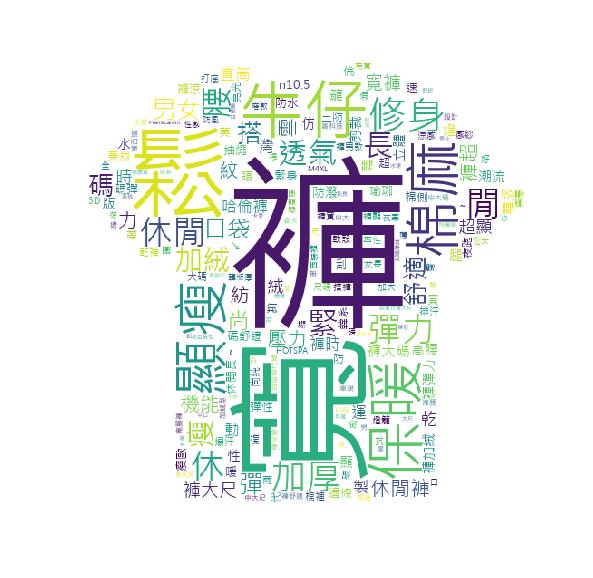

In [116]:
plt.figure(figsize=(10,10))
plt.imshow(my_wordcloud)
plt.axis('off')
plt.show()

### 對資料做轉化

In [29]:
df['content_cutted'] = df['item_name'].apply(word_cut)

In [30]:
content_cutted = pd.Series([dictionary.doc2bow(x) for x in df['content_cutted']])

In [31]:
content_cutted[:5]

0    [(2975, 1), (9658, 1), (51473, 1), (52532, 1),...
1    [(390, 1), (1370, 1), (2975, 1), (19814, 1), (...
2    [(390, 1), (1370, 1), (2975, 1), (19814, 1), (...
3    [(390, 1), (1370, 1), (2975, 1), (19814, 1), (...
4    [(390, 1), (1370, 1), (2975, 1), (19814, 1), (...
dtype: object

In [32]:
content_cutted2 = pd.Series(map( lambda x: list(map( lambda y: y[0]  ,x)),
                                       content_cutted))
content_cutted2[:5]

0    [2975, 9658, 51473, 52532, 77790, 77908, 78261...
1               [390, 1370, 2975, 19814, 20260, 21258]
2               [390, 1370, 2975, 19814, 20260, 21258]
3               [390, 1370, 2975, 19814, 20260, 21258]
4               [390, 1370, 2975, 19814, 20260, 21258]
dtype: object

### 特徵欄位

In [33]:
def word(x):
    stroke = []
    for i in range(0,len(code_tokenGyTfidfSort4)):
        c = 0
        for j in x:
            if j in code_tokenGyTfidfSort4[i]: #比對分群關鍵字
                c = c + 1
        stroke.append(c)
    return(stroke)

In [35]:
%%time
BB = []
BB.append(list(content_cutted2[:1].apply(word)))

Wall time: 27 ms


In [36]:
BB

[[[0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   2,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   1,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   2,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   2,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   1,
   2,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   2,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   6,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0

In [115]:
AA = []
AA.append(list(content_cutted2.apply(word)))

In [117]:
df_AA = pd.DataFrame(AA[0])

In [118]:
df_AA['newCode'] = df['newCode']

In [119]:
df_AA.to_csv(r"D:\MyPython\專題\答3.csv")